#### 1. 生成模拟数据集。

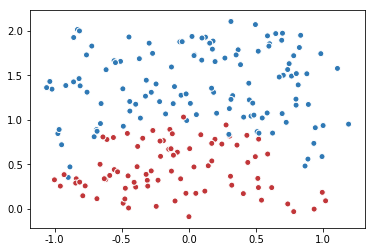

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

dataset_size = 200
data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(dataset_size):
    x1 = np.random.uniform(-1,1)
    x2 = np.random.uniform(0,2)
    if x1**2 + x2**2 <= 1:
        data.append([np.random.normal(x1, 0.1),np.random.normal(x2,0.1)])
        label.append(0)
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(1)
        
data = np.hstack(data).reshape(-1,2)
label = np.hstack(label).reshape(-1, 1)
plt.scatter(data[:,0], data[:,1], c=label.reshape(200,),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.show()

#### 2. 定义一个获取权重，并自动加入正则项到损失的函数。一般tf.Variable都是需要训练的权重参数

In [12]:
def get_weight(shape, var_lambda):
    # 生成一个变量
    w = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # 将新生成变量的L2正则化损失加入集合
    # losses是集合名，其后是要加入集合的内容
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(var_lambda)(w))
    return w

#### 3. 定义神经网络。

In [17]:
x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))

# 定义每层网络中节点的个数
layer_dimension = [2,10,5,3,1]
# 神经网络层数
n_layers = len(layer_dimension)

# 该变量维护前向传播时最深层的节点，开始的时候就是输入层
cur_layer = x
# 当前层的节点个数
in_dimension = layer_dimension[0]

# 通过循环来生成5层全连接的神经网络结构
# 输入层X[None, 2]
# 隐藏层W1[2, 10]、W2[10, 5]、W3[5, 3]
# 输出层Y[None, 1]
for i in range(1, n_layers):
    # 下一层的节点个数
    out_dimension = layer_dimension[i]
    # 生成当前层中权重的变量weight，并将这个变量的L2正则化损失加入计算图上的集合
    weight = get_weight([in_dimension, out_dimension], 0.003)
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    # 使用ReLU激活函数
    cur_layer = tf.nn.elu(tf.matmul(cur_layer, weight) + bias)
    # 进入下一层之前将下一层的节点个数更新为当前层节点个数
    in_dimension = layer_dimension[i]

y= cur_layer

# 在神经网络前向传播的同时，已经将所有的L2正则化损失加入了图上的集合
# 这里只需要计算模型在训练数据上表现的损失函数
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2)) / dataset_size
# 将均方差误差损失函数加入损失集合
tf.add_to_collection('losses', mse_loss)
# get_collection 返回一个列表，这个列表是所有这个集合中的元素。
# 该元素是损失函数的不同部分，将它们加起来就可以得到最终的损失函数
loss = tf.add_n(tf.get_collection('losses'))

#### 4. 训练不带正则项的损失函数mse_loss。

After 999 steps, mse_loss: 0.066249
After 1999 steps, mse_loss: 0.060282
After 2999 steps, mse_loss: 0.050951
After 3999 steps, mse_loss: 0.043452
After 4999 steps, mse_loss: 0.037738
After 5999 steps, mse_loss: 0.035935
After 6999 steps, mse_loss: 0.033375
After 7999 steps, mse_loss: 0.027632
After 8999 steps, mse_loss: 0.022587
After 9999 steps, mse_loss: 0.020984


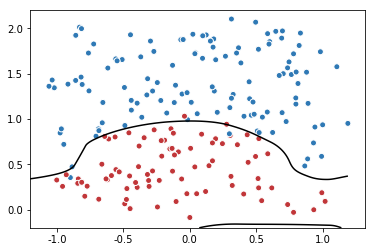

In [22]:
# 定义训练的目标函数mse_loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(mse_loss)
TRAINING_STEPS = 10000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 1000 == 1000 - 1:
            print("After %d steps, mse_loss: %f" % (i,sess.run(mse_loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1.2:1.2:.01, -0.2:2.2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=label.reshape(200,),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()

#### 5. 训练带正则项的损失函数loss。
这里有点奇怪，一直运行出错：

```
InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [?,1]
```

我将 x,y_,data,label的shape都打印出来，并没有发现问题。不知道错在何处。

In [25]:
# 定义训练的目标函数loss，训练次数及训练模型
train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
TRAINING_STEPS = 10000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        print(x.get_shape(), y_.get_shape())
        print(data.shape, label.shape)
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 1000 == 1000 - 1:
            print("After %d steps, loss: %f" % (i, sess.run(loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线       
    xx, yy = np.mgrid[-1:1:.01, 0:2:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x:grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:,0], data[:,1], c=label.reshape(200,),
           cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()

(?, 2) (?, 1)
(200, 2) (200, 1)


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [?,1]
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_3', defined at:
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-9a1b2a635d24>", line 2, in <module>
    y_ = tf.placeholder(tf.float32, shape=(None, 1))
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [?,1]
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
